# Test: RNA-seq Data from TCGA via UCI ML Repo

To test the multiclass SVM on high-dimensional data as originally planned, RNA-seq data from the Cancer Genome Atlas (TCGA) is used to predict the type of cancer per sample out of five possible types.

---

#### Imports

In [1]:
from time import perf_counter

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.random_projection import SparseRandomProjection

# For comparison
from sklearn.svm import SVC, LinearSVC

# Local import
from svm import MultiGDSVM
import dim_reduction

---

#### Load Data

In [2]:
path = "data/TCGA-PANCAN-HiSeq-801x20531/"

raw = pd.read_csv(path + "data.csv").iloc[:, 1:]
labels = pd.read_csv(path + "labels.csv").iloc[:, 1:]

In [3]:
# Merge X and y
raw = pd.concat([raw, labels], axis=1)

# Move class to front
col = raw.pop("Class")
raw.insert(0, col.name, col)

In [4]:
raw

,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,PRAD,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,LUAD,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,PRAD,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,PRAD,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,BRCA,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,BRCA,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,LUAD,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,COAD,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,PRAD,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


---

#### Preprocessing

In [5]:
X = raw.iloc[:, 1:]
y = raw.iloc[:, 0]

In [6]:
# Scale input features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Encode target labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

---

#### RBF Hyperparameter Tuning

In [7]:
n_dims = 15_000

# Perform dimensionality reduction
X_cur = SparseRandomProjection(n_dims).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_cur, y, test_size=0.2, random_state=2)

In [8]:
svm = MultiGDSVM(kernel="rbf", batch_size=64, beta1=0.95, beta2=0.999, gamma=0.01)

t0 = perf_counter()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(f"Time: {perf_counter() - t0}")

print(f"Accuracy: {(y_pred == y_test).sum() / y_pred.shape[0]:.4f}")

Time: 134.842792200041
Accuracy: 0.8944


---

#### N-Fold CV

In [9]:
from sklearn.model_selection import cross_val_score

In [10]:
svm = MultiGDSVM(kernel="linear", C=1, verbose=False)

In [11]:
nfold_scores = {}

In [12]:
%%time

# Accuracy
nfold_scores["accuracy"] = cross_val_score(svm, X, y, cv=5, scoring="accuracy")

CPU times: total: 8.44 s
Wall time: 2.65 s


In [13]:
%%time

# F1-score w/ micro weighting
nfold_scores["f1_micro"] = cross_val_score(svm, X, y, cv=5, scoring="f1_micro")

CPU times: total: 7.52 s
Wall time: 2.68 s


In [14]:
%%time

# F1-score w/ micro weighting
nfold_scores["f1_macro"] = cross_val_score(svm, X, y, cv=5, scoring="f1_macro")

CPU times: total: 7.84 s
Wall time: 2.67 s


In [15]:
df = pd.DataFrame(nfold_scores)
df["fold"] = [i for i in range(df.shape[0])]
df = pd.melt(df, id_vars="fold", value_vars=["accuracy", "f1_micro", "f1_macro"], var_name="metric", value_name="score")
df

,fold,metric,score
0,0,accuracy,0.993789
1,1,accuracy,0.987500
2,2,accuracy,0.993750
3,3,accuracy,0.993750
4,4,accuracy,1.000000
5,0,f1_micro,0.993789
6,1,f1_micro,0.993750
7,2,f1_micro,0.993750
8,3,f1_micro,1.000000
9,4,f1_micro,1.000000


In [47]:
df.groupby("metric").mean()

,fold,score
metric,,
accuracy,2.0,0.993758
f1_macro,2.0,0.992784
f1_micro,2.0,0.996258


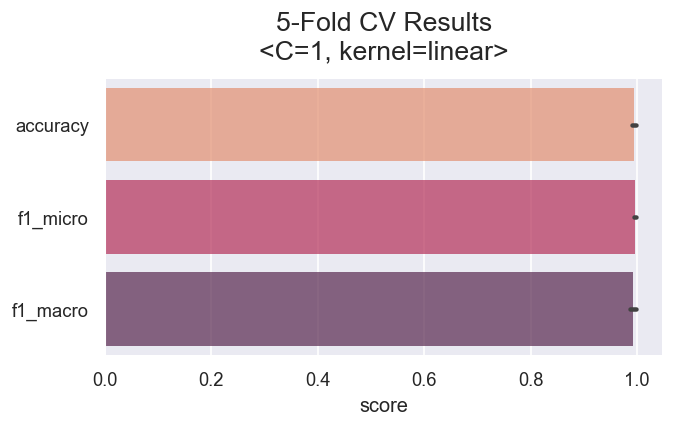

In [16]:
plt.figure(figsize=(6, 3), dpi=120)

sns.barplot(
    data=df, y="metric", x="score", orient="h", linewidth=0.0, 
    palette="rocket_r", errorbar="ci", width=0.8, alpha=0.7,
)

title = f"{df.fold.unique().shape[0]}-Fold CV Results"
title += f"\n<C={svm.C}, kernel={svm.kernel}>"
plt.title(title, pad=12, fontsize=16)
plt.ylabel("")
plt.show()

---

#### Time Comparisons

In [17]:
def time_models(X, y, names, models,):
    times = dict()
    scores = dict()

    for name, model in zip(names, models):
        t0 = perf_counter()
        scores[name] = cross_val_score(model, X, y, cv=5, scoring="accuracy")

        times[name] = perf_counter() - t0

    return times, scores

***Linear***

In [18]:
#svc = SVC(kernel="linear")
lsvc = LinearSVC()
svm = MultiGDSVM(kernel="linear", verbose=False)  # My implementation

linear_times, linear_scores = time_models(X, y, ["sk_svc", "my_svc"], [lsvc, svm])

In [19]:
linear_times

{'sk_svc': 23.709036299958825, 'my_svc': 2.758580800029449}

In [20]:
linear_scores

{'sk_svc': array([0.99378882, 1.        , 1.        , 1.        , 1.        ]),
 'my_svc': array([1.   , 1.   , 1.   , 0.975, 1.   ])}

**Poly**

In [21]:
svc = SVC(kernel="poly")
svm = MultiGDSVM(kernel="poly", verbose=False)  # My implementation

poly_times, poly_scores = time_models(X, y, ["sk_svc", "my_svc"], [svc, svm])

In [22]:
poly_times

{'sk_svc': 101.83871429995634, 'my_svc': 2.9722706000320613}

In [23]:
poly_scores

{'sk_svc': array([0.99378882, 1.        , 1.        , 1.        , 1.        ]),
 'my_svc': array([0.99378882, 1.        , 0.9375    , 0.98125   , 0.9875    ])}

***RBF***

In [24]:
n_dims = 15_000

# Perform dimensionality reduction
X_cur = SparseRandomProjection(n_dims).fit_transform(X)

In [25]:
svc = SVC(kernel="rbf")
svm = MultiGDSVM(kernel="rbf", batch_size=64, beta1=0.95, beta2=0.999, gamma=0.01, verbose=False) # My implementation

rbf_times, rbf_scores = time_models(X_cur, y, ["sk_svc", "my_svc"], [svc, svm])

In [26]:
rbf_times

{'sk_svc': 137.789977400098, 'my_svc': 663.563272499945}

In [27]:
rbf_scores

{'sk_svc': array([0.99378882, 1.        , 1.        , 1.        , 0.99375   ]),
 'my_svc': array([0.9068323, 0.9625   , 0.91875  , 0.9625   , 0.90625  ])}

***Viz***

In [28]:
all_scores = [pd.DataFrame(scores) for scores in [linear_scores, poly_scores, rbf_scores]]

for i, name in enumerate(["linear", "poly", "rbf"]):
    all_scores[i]["kernel"] = name
    all_scores[i] = pd.melt(all_scores[i], id_vars="kernel", value_vars=["sk_svc", "my_svc"], var_name="model", value_name="score")

all_scores = pd.concat(all_scores)
all_scores.head(3)

,kernel,model,score
0,linear,sk_svc,0.993789
1,linear,sk_svc,1.000000
2,linear,sk_svc,1.000000


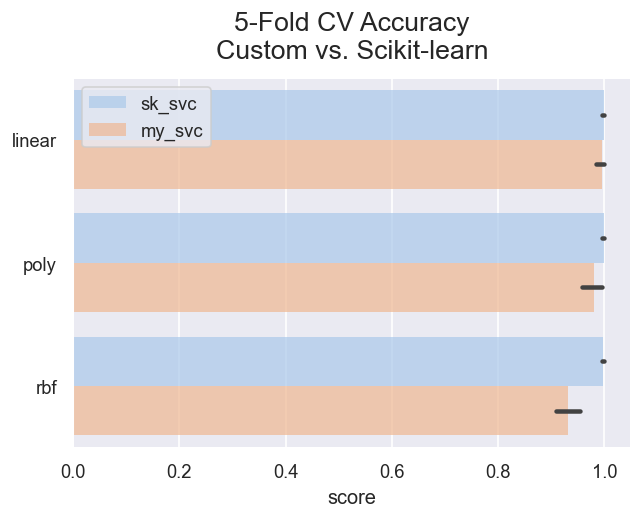

In [29]:
plt.figure(figsize=(6, 4), dpi=120)

sns.barplot(
    data=all_scores, y="kernel", x="score", hue="model", orient="h", linewidth=0.0, 
    palette="pastel", errorbar="ci", width=0.8, alpha=0.7,
)

title = f"{df.fold.unique().shape[0]}-Fold CV Accuracy\nCustom vs. Scikit-learn"
plt.title(title, pad=12, fontsize=16)
plt.ylabel("")
plt.legend(loc="upper left")
plt.show()

In [30]:
all_times = [times for times in [linear_times, poly_times, rbf_times]]
all_times = pd.DataFrame(all_times)
all_times["kernel"] = ["linear", "poly", "rbf"]

all_times = pd.melt(all_times, id_vars="kernel", value_vars=["sk_svc", "my_svc"], var_name="model", value_name="time")

all_times

,kernel,model,time
0,linear,sk_svc,23.709036
1,poly,sk_svc,101.838714
2,rbf,sk_svc,137.789977
3,linear,my_svc,2.758581
4,poly,my_svc,2.972271
5,rbf,my_svc,663.563272


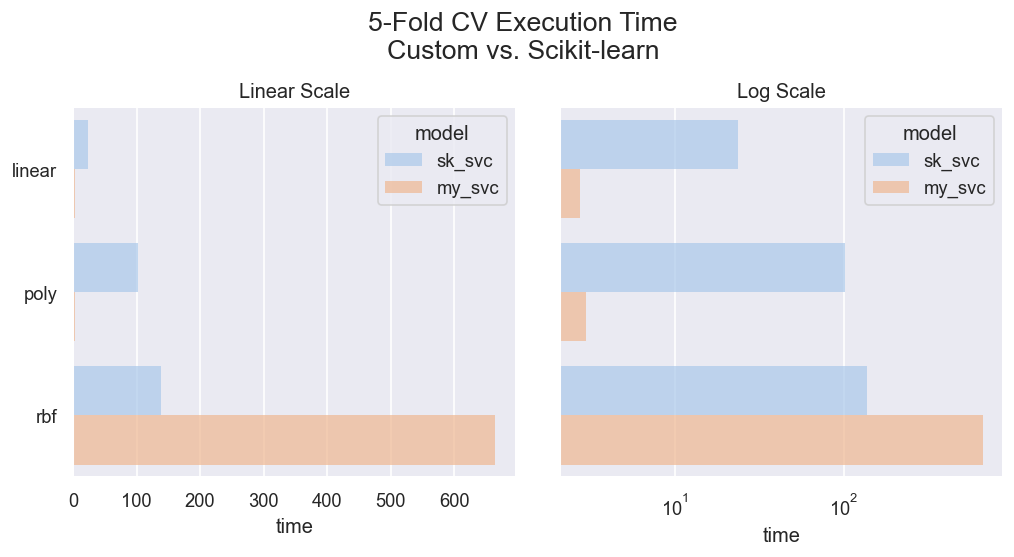

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

for i, ax in enumerate(axes):
    sns.barplot(
        data=all_times, y="kernel", x="time", hue="model", orient="h", linewidth=0.0, 
        palette="pastel", width=0.8, alpha=0.7,
        ax=ax
    )
    ax.set_ylabel("")
    ax.set_title("Linear Scale" if i == 0 else "Log Scale")

axes[1].set_xscale("log")

title = f"{df.fold.unique().shape[0]}-Fold CV Execution Time\nCustom vs. Scikit-learn"
plt.suptitle(title, fontsize=16, y=1.08)
plt.subplots_adjust(wspace=0.1)
plt.show()

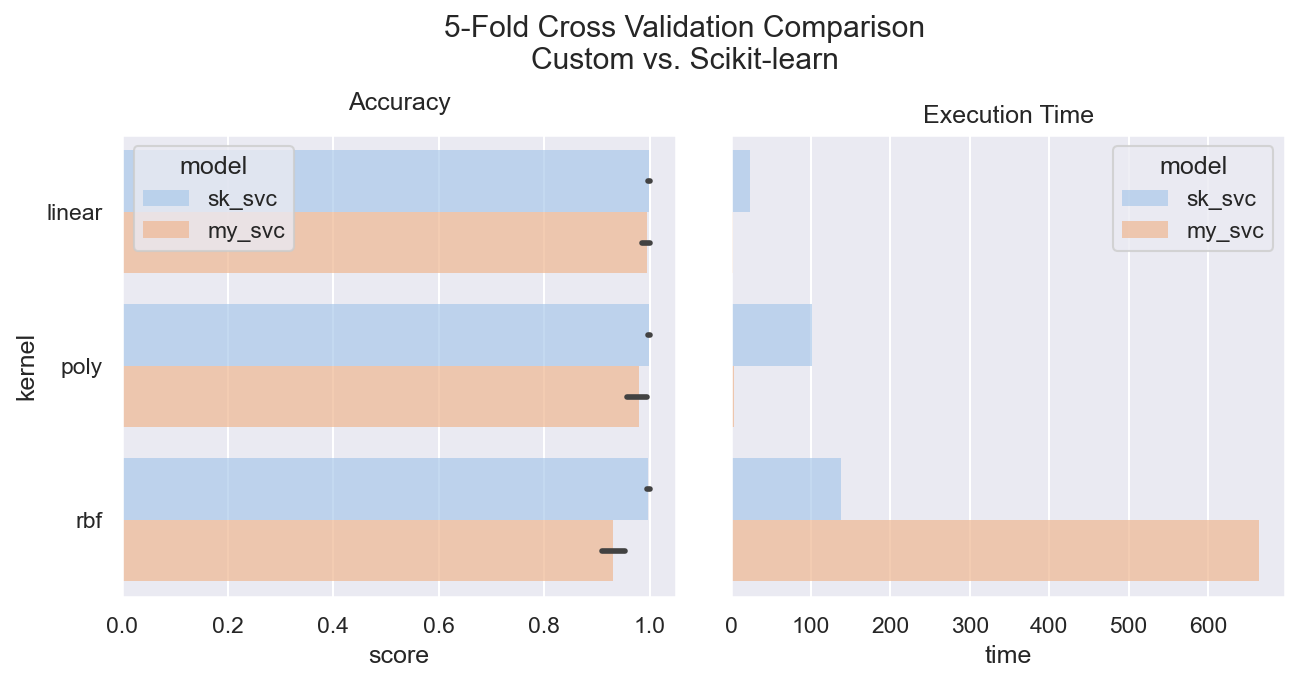

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150, sharey=True)


sns.barplot(
    data=all_times, y="kernel", x="time", hue="model", orient="h", linewidth=0.0, 
    palette="pastel", width=0.8, alpha=0.7,
    ax=axes[1]
)
axes[1].set_ylabel("")
axes[1].set_title(f"Execution Time")

sns.barplot(
    data=all_scores, y="kernel", x="score", hue="model", orient="h", linewidth=0.0, 
    palette="pastel", errorbar="ci", width=0.8, alpha=0.7, ax=axes[0],
)

title = f"{df.fold.unique().shape[0]}-Fold Cross Validation Comparison\nCustom vs. Scikit-learn"
axes[0].set_title("Accuracy", pad=12)

plt.suptitle(title, y=1.08)
plt.subplots_adjust(wspace=0.1)

plt.ylabel("")
plt.show()